In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV


# Data Processing

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [15]:
# Checking for missing values in training and testing datasets
missing_train = train_df.isnull().sum().sort_values(ascending=False)
missing_test = test_df.isnull().sum().sort_values(ascending=False)

# Getting the top 10 columns with the most missing values for both datasets
missing_train_top10 = missing_train[missing_train > 0]
missing_test_top10 = missing_test[missing_test > 0]

missing_train_top10, missing_test_top10


(CryoSleep       217
 ShoppingMall    208
 VIP             203
 HomePlanet      201
 Name            200
 Cabin           199
 VRDeck          188
 FoodCourt       183
 Spa             183
 Destination     182
 RoomService     181
 Age             179
 dtype: int64,
 FoodCourt       106
 Spa             101
 Cabin           100
 ShoppingMall     98
 Name             94
 CryoSleep        93
 VIP              93
 Destination      92
 Age              91
 HomePlanet       87
 RoomService      82
 VRDeck           80
 dtype: int64)

In [18]:
# Impute missing values

# Impute 'Age' with median
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

# Impute categorical and boolean columns with mode
columns_with_mode = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
for column in columns_with_mode:
    mode_value = train_df[column].mode()[0]
    train_df[column].fillna(mode_value, inplace=True)

# Impute billing columns with 0
billing_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df[billing_columns] = train_df[billing_columns].fillna(0)

# Check for remaining missing values
remaining_missing = train_df.isnull().sum()

remaining_missing

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

In [19]:
# Extracting information from the 'Cabin' column
train_df['Deck'] = train_df['Cabin'].str.split('/').str[0]
train_df['Num'] = train_df['Cabin'].str.split('/').str[1]
train_df['Side'] = train_df['Cabin'].str.split('/').str[2]

# Drop the 'Name' and original 'Cabin' columns
train_df = train_df.drop(columns=['Name', 'Cabin'])

# Display the first few rows after feature engineering
train_df.head()


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [20]:
# One-hot encoding of categorical columns
categorical_columns = ['HomePlanet', 'Destination', 'Deck', 'Num', 'Side']
train_data_encoded = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)

# Display the first few rows after one-hot encoding
train_data_encoded.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Num_991,Num_992,Num_993,Num_994,Num_995,Num_996,Num_997,Num_998,Num_999,Side_S
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,...,0,0,0,0,0,0,0,0,0,0
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,...,0,0,0,0,0,0,0,0,0,1
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,...,0,0,0,0,0,0,0,0,0,1
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,...,0,0,0,0,0,0,0,0,0,1
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,...,0,0,0,0,0,0,0,0,0,1


In [22]:

# List of numerical columns to scale
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the numerical columns
train_data_encoded[numerical_columns] = scaler.fit_transform(train_data_encoded[numerical_columns])

# Display the first few rows after scaling
train_data_encoded.head()


,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,Num_991,Num_992,Num_993,Num_994,Num_995,Num_996,Num_997,Num_998,Num_999,Side_S
0,0001_01,False,0.711945,False,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,False,...,0,0,0,0,0,0,0,0,0,0
1,0002_01,False,-0.334037,False,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,True,...,0,0,0,0,0,0,0,0,0,1
2,0003_01,False,2.036857,True,-0.268001,1.959998,-0.283579,5.695623,-0.219796,False,...,0,0,0,0,0,0,0,0,0,1
3,0003_02,False,0.293552,False,-0.333105,0.523010,0.336851,2.687176,-0.092818,False,...,0,0,0,0,0,0,0,0,0,1
4,0004_01,False,-0.891895,False,0.125652,-0.237159,-0.031059,0.231374,-0.261240,True,...,0,0,0,0,0,0,0,0,0,1


In [23]:
# Features and target variable
X = train_data_encoded.drop(columns=['PassengerId', 'Transported'])
y = train_data_encoded['Transported']

# Splitting the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6954, 1836), (1739, 1836), (6954,), (1739,))

# Model building

In [30]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = rf_classifier.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)

accuracy

0.7878090856814262

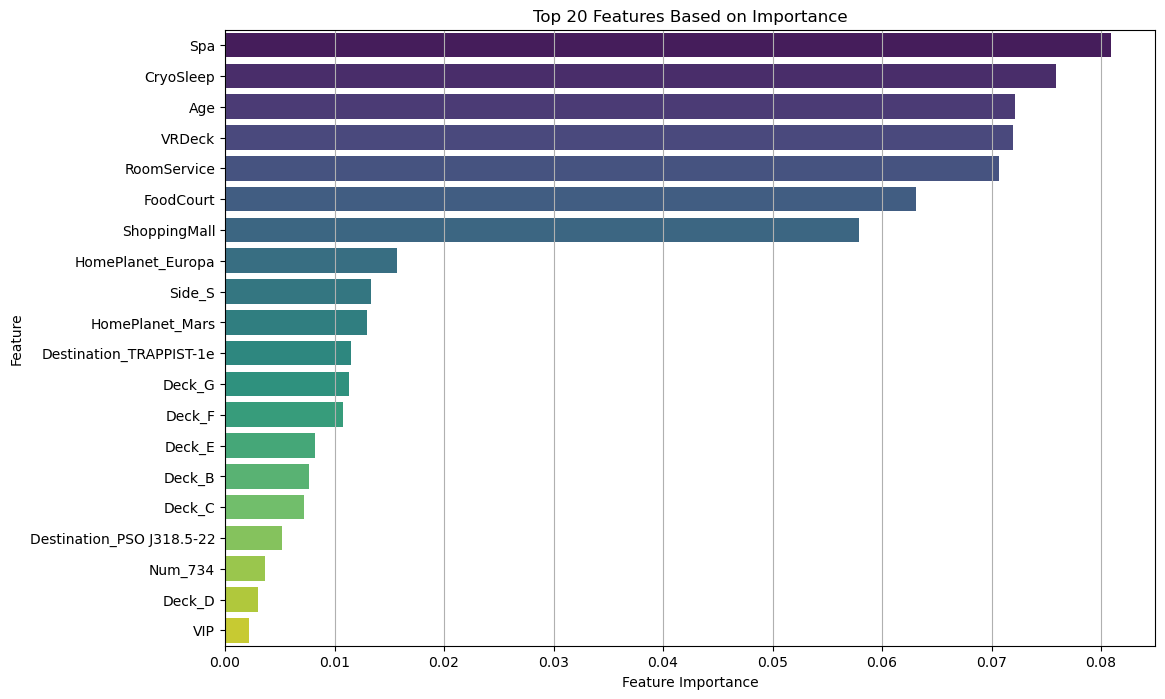

In [31]:
# Extracting feature importance from the Random Forest model
feature_importance = rf_classifier.feature_importances_

# Creating a DataFrame for feature importance
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sorting the features based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Displaying the top 20 features based on importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(20), palette='viridis')
plt.title('Top 20 Features Based on Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x')
plt.show()


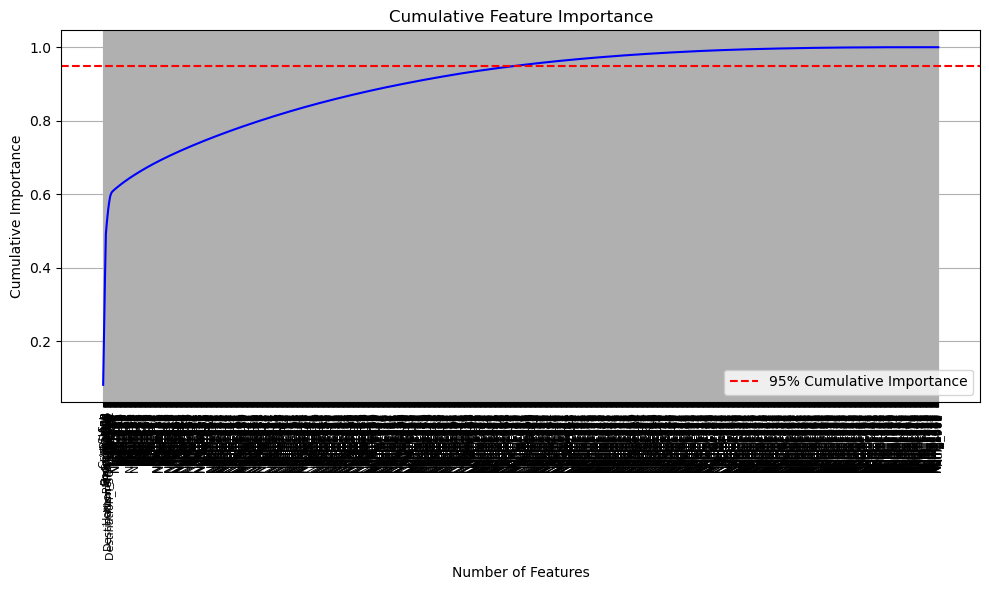

911

In [32]:
# Calculate cumulative importance
features_df['Cumulative Importance'] = features_df['Importance'].cumsum()

# Plotting cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(features_df['Feature'], features_df['Cumulative Importance'], 'b-')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Cumulative Importance")
plt.legend(loc="lower right")
plt.grid(True)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# Suggesting the number of features for the 95% threshold
suggested_features = features_df[features_df['Cumulative Importance'] <= 0.95].shape[0]
suggested_features


In [33]:
# Selecting the top 911 features
selected_features = features_df.head(suggested_features)['Feature'].tolist()

# Reducing the feature set for training and validation data
X_train_reduced = X_train[selected_features]
X_val_reduced = X_val[selected_features]

X_train_reduced.shape, X_val_reduced.shape


((6954, 911), (1739, 911))

In [34]:
# Retraining the Random Forest classifier on the reduced feature set
rf_classifier_reduced = RandomForestClassifier(random_state=42)
rf_classifier_reduced.fit(X_train_reduced, y_train)

# Predicting on the validation set with the reduced feature set
y_val_pred_reduced = rf_classifier_reduced.predict(X_val_reduced)

# Evaluating the model's performance with the reduced feature set
accuracy_reduced = accuracy_score(y_val, y_val_pred_reduced)
classification_rep_reduced = classification_report(y_val, y_val_pred_reduced)

accuracy_reduced, classification_rep_reduced


(0.7883841288096607,
 '              precision    recall  f1-score   support\n\n       False       0.79      0.78      0.79       861\n        True       0.79      0.79      0.79       878\n\n    accuracy                           0.79      1739\n   macro avg       0.79      0.79      0.79      1739\nweighted avg       0.79      0.79      0.79      1739\n')

In [36]:
# Defining the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize GridSearchCV with the model and hyperparameters
grid_search = GridSearchCV(estimator=rf_classifier_reduced, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_reduced, y_train)

# Extracting the best parameters and the best estimator from the grid search
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

best_params


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/dragonsave/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dragonsave/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/dragonsave/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove 

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 150}

In [37]:
# Training the Random Forest classifier with the optimal hyperparameters
rf_optimized = RandomForestClassifier(**best_params, random_state=42)
rf_optimized.fit(X_train_reduced, y_train)

# Predicting on the validation set with the optimized model
y_val_pred_optimized = rf_optimized.predict(X_val_reduced)

# Evaluating the optimized model's performance
accuracy_optimized = accuracy_score(y_val, y_val_pred_optimized)
classification_rep_optimized = classification_report(y_val, y_val_pred_optimized)

accuracy_optimized, classification_rep_optimized

/Users/dragonsave/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


(0.78953421506613,
 '              precision    recall  f1-score   support\n\n       False       0.79      0.78      0.79       861\n        True       0.79      0.80      0.79       878\n\n    accuracy                           0.79      1739\n   macro avg       0.79      0.79      0.79      1739\nweighted avg       0.79      0.79      0.79      1739\n')

In [39]:
# Handling missing values for the test data again
test_df['Age'].fillna(train_df['Age'].median(), inplace=True)
for column in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']:
    mode_value = train_df[column].mode()[0]
    test_df[column].fillna(mode_value, inplace=True)
test_df[billing_columns] = test_df[billing_columns].fillna(0)

# Feature Engineering for the test data
test_df['Deck'] = test_df['Cabin'].str.split('/').str[0]
test_df['Num'] = test_df['Cabin'].str.split('/').str[1]
test_df['Side'] = test_df['Cabin'].str.split('/').str[2]
test_df = test_df.drop(columns=['Name', 'Cabin'])

# One-hot encoding for the test data
test_data_encoded = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)
# Ensure the test data has the same columns as the training data
for col in X_train_reduced.columns:
    if col not in test_data_encoded.columns:
        test_data_encoded[col] = 0
test_data_encoded = test_data_encoded[X_train_reduced.columns]

# Scaling the numerical columns for the test data
test_data_encoded[numerical_columns] = scaler.transform(test_data_encoded[numerical_columns])

# Making predictions using the optimized model
test_predictions = rf_optimized.predict(test_data_encoded)

test_predictions[:10]  # Displaying the first 10 predictions


/var/folders/y6/182wld891cn8s93gftsfv4nr0000gn/T/ipykernel_62905/2776956336.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data_encoded[col] = 0
/var/folders/y6/182wld891cn8s93gftsfv4nr0000gn/T/ipykernel_62905/2776956336.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data_encoded[col] = 0
/var/folders/y6/182wld891cn8s93gftsfv4nr0000gn/T/ipykernel_62905/2776956336.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

array([ True, False,  True,  True, False, False,  True,  True,  True,
       False])

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   4.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   3.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.7s
[CV] END max_depth=None

In [43]:
# Save the submission dataframe to a CSV file
submission_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': test_predictions
})

submission_path = "/Users/dragonsave/Documents/Master behavior finance/Kaggle/spaceship-titanic/titanic_spaceship.csv"
submission_df.to_csv(submission_path, index=False)

submission_file_path


'/Users/dragonsave/Documents/Master behavior finance/Kaggle/spaceship-titanic/titanic_spaceship.csv'